In [1]:
!pip install keras

In [2]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
import os, tarfile, zipfile
from glob import glob
import distutils
from distutils import dir_util

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation, Input, Activation
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, ZeroPadding2D, AveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.imagenet_utils import preprocess_input
from keras.engine.topology import get_source_inputs
from keras import layers
from keras.utils.data_utils import get_file



import tensorflow as tf
print(tf.test.gpu_device_name())

%matplotlib inline

Using TensorFlow backend.


/device:GPU:0


In [0]:
fruit360_URL = 'https://www.dropbox.com/s/ui10iyp9kwawlf3/fruits-360_dataset_2018_02_08.zip?dl=1'

# Utility functions

In [0]:
def fetch_data(URL, DOWNLOAD_FOLDER, DOWNLOAD_FILE):
  if not os.path.isdir(DOWNLOAD_FOLDER):
   os.makedirs(DOWNLOAD_FOLDER)
  
  if not os.path.isfile(DOWNLOAD_FOLDER+DOWNLOAD_FILE):
    print('Beginning file download...')
    urllib.request.urlretrieve(URL, DOWNLOAD_FOLDER+DOWNLOAD_FILE)
    print('Done.')
  

In [0]:
def split_train_test(XY, n_splits=1, test_size=0.2, random_state=42):
    split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(XY[0], XY[1]):
        X_train, Y_train = XY[0][train_index,:], XY[1][train_index]
        X_test, Y_test = XY[0][test_index,:], XY[1][test_index]
        
    return X_train, Y_train, X_test, Y_test

In [0]:
def mkdir(p):
    if not os.path.exists(p):
        os.makedirs(p)

def copy_dirs(src, dst):
    distutils.dir_util.copy_tree(src, dst)

def link(src, dest):
    if not os.path.exists(dest):
        os.c(src, dest, target_is_directory=True)

def make_small_dataset(train_path, valid_path, classes):
    train_path_from = os.path.abspath(train_path[0])
    valid_path_from = os.path.abspath(valid_path[0])

    train_path_to = os.path.abspath(train_path[1])
    valid_path_to = os.path.abspath(valid_path[1])
    
    mkdir(train_path_to)
    mkdir(valid_path_to)
    
    for c in classes:
        if not os.path.exists(train_path_to+'/'+c):
            copy_dirs(train_path_from+'/'+c, train_path_to+'/'+c)
        if not os.path.exists(valid_path_to+'/'+c):
            copy_dirs(valid_path_from+'/'+c, valid_path_to+'/'+c)

In [0]:
def get_fruit360_data(url, zip_folder, zip_file, extract_loc):
    
    fetch_data(url, zip_folder, zip_file)
    mkdir(extract_loc)
    zip_ref = zipfile.ZipFile(zip_folder+zip_file, 'r')
    zip_ref.extractall(extract_loc)
    zip_ref.close()
    

In [0]:
def one_hot_encoder(label):
    encoder = OneHotEncoder(dtype=np.float32)
    label_1hot = encoder.fit_transform(label.reshape(-1,1))
    print('The labels are: {}'.format(np.unique(label)))
    return label_1hot

# Load data

In [0]:
root_folder = '/content/drive/app/'
# root_folder = 'D:/dev/data/'

In [10]:
get_fruit360_data(fruit360_URL, root_folder, 'fruits-360_dataset_2018_02_08.zip', root_folder+'large_set/')

Beginning file download...
Done.


In [0]:
classes = ['Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 'Carambula', 'Cherry', 'Clementine', 'Cocos', 'Dates', 'Granadilla', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry']

train_path = [root_folder+'large_set/fruits-360/Training/', root_folder+'small_set_1/fruits-360/Training/']
valid_path = [root_folder+'large_set/fruits-360/Validation/', root_folder+'small_set_1/fruits-360/Validation/']
valid_path = [root_folder+'large_set/fruits-360/Validation/', root_folder+'small_set_1/fruits-360/Validation/']

make_small_dataset(train_path=train_path, valid_path=valid_path, classes=classes)



In [12]:
!pwd
print(train_path[1])
print(valid_path[1])
# !ls -l 'drive/app/small_set/fruits-360/'
# !ls -l /content/drive/app/small_set_1/fruits-360/Training/
# !ls -l /content/drive/app/small_set_1/fruits-360/Validation/

# !ls -l /content/drive/app/small_set_1/fruits-360/Training/Avocado/

/content
/content/drive/app/small_set_1/fruits-360/Training/
/content/drive/app/small_set_1/fruits-360/Validation/


# Model definition

In [0]:
#@title Parameters
SELECTED = 0
train_folders = glob(train_path[SELECTED]+'/*')
train_images = glob(train_path[SELECTED]+'/*/*.jp*g')
valid_images = glob(valid_path[SELECTED]+'/*/*.jp*g')

IMAGE_SIZE = [100,100]
BATCH_SIZE = 32
EPOCHS = 16

In [25]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(100,100,3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(256,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(512,(3,3),padding='valid'))
model.add(Activation('relu'))

model.add(Conv2D(len(train_folders),(1,1),padding='valid'))
model.add(GlobalMaxPooling2D())
model.add(Activation('softmax'))


# model.add(Dense(256,activation='relu'))
# #model.add(LeakyReLU(0.1))
# model.add(Dropout(0.5))
# model.add(Dense(len(train_folders)))
# model.add(Activation("softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
activation_69 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
activation_70 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 50, 50, 64)        18496     
__________

In [26]:
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)
train_generator = datagen.flow_from_directory(train_path[SELECTED], target_size=IMAGE_SIZE,
                                              batch_size=BATCH_SIZE, shuffle=True)


valid_generator = datagen.flow_from_directory(valid_path[SELECTED], target_size=IMAGE_SIZE,
                                              batch_size=BATCH_SIZE, shuffle=False)


Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.


In [0]:
optimizer = RMSprop(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit_generator(train_generator, epochs=EPOCHS, validation_data=valid_generator, steps_per_epoch=len(train_images) // BATCH_SIZE, 
                              validation_steps=len(valid_images) // BATCH_SIZE)

Epoch 1/16
898/898 [==============================] - 177s 197ms/step - loss: 0.8506 - acc: 0.7444 - val_loss: 0.4655 - val_acc: 0.8635
Epoch 2/16
 77/898 [=>............................] - ETA: 1:55 - loss: 0.2503 - acc: 0.9209

898/898 [==============================] - 174s 194ms/step - loss: 0.1814 - acc: 0.9436 - val_loss: 0.2107 - val_acc: 0.9364
Epoch 3/16
155/898 [====>.........................] - ETA: 1:49 - loss: 0.1473 - acc: 0.9563

898/898 [==============================] - 175s 195ms/step - loss: 0.1199 - acc: 0.9654 - val_loss: 0.3802 - val_acc: 0.9177
Epoch 4/16
185/898 [=====>........................] - ETA: 1:46 - loss: 0.1071 - acc: 0.9715

898/898 [==============================] - 175s 194ms/step - loss: 0.0952 - acc: 0.9725 - val_loss: 1.4943 - val_acc: 0.7735
Epoch 5/16
196/898 [=====>........................] - ETA: 1:44 - loss: 0.0837 - acc: 0.9775

898/898 [==============================] - 174s 194ms/step - loss: 0.0828 - acc: 0.9783 - val_loss: 0.6352 - val_acc: 0.8905
Epoch 6/16
200/898 [=====>........................] - ETA: 1:43 - loss: 0.0667 - acc: 0.9812

898/898 [==============================] - 173s 193ms/step - loss: 0.0683 - acc: 0.9809 - val_loss: 0.5858 - val_acc: 0.9005
Epoch 7/16
201/898 [=====>........................] - ETA: 1:41 - loss: 0.0784 - acc: 0.9810

898/898 [==============================] - 172s 192ms/step - loss: 0.0700 - acc: 0.9824 - val_loss: 0.1177 - val_acc: 0.9669
Epoch 8/16
202/898 [=====>........................] - ETA: 1:43 - loss: 0.0626 - acc: 0.9825

898/898 [==============================] - 174s 193ms/step - loss: 0.0608 - acc: 0.9835 - val_loss: 0.0966 - val_acc: 0.9771
Epoch 9/16
202/898 [=====>........................] - ETA: 1:42 - loss: 0.0537 - acc: 0.9865

898/898 [==============================] - 173s 192ms/step - loss: 0.0605 - acc: 0.9858 - val_loss: 0.0796 - val_acc: 0.9790
Epoch 10/16
201/898 [=====>........................] - ETA: 1:43 - loss: 0.0475 - acc: 0.9888

898/898 [==============================] - 173s 192ms/step - loss: 0.0552 - acc: 0.9869 - val_loss: 0.1100 - val_acc: 0.9721
Epoch 11/16
201/898 [=====>........................] - ETA: 1:43 - loss: 0.0618 - acc: 0.9848

898/898 [==============================] - 172s 192ms/step - loss: 0.0513 - acc: 0.9877 - val_loss: 0.1230 - val_acc: 0.9750
Epoch 12/16
201/898 [=====>........................] - ETA: 1:43 - loss: 0.0456 - acc: 0.9894

898/898 [==============================] - 173s 192ms/step - loss: 0.0498 - acc: 0.9880 - val_loss: 0.3674 - val_acc: 0.9340
Epoch 13/16
201/898 [=====>........................] - ETA: 1:42 - loss: 0.0522 - acc: 0.9890

898/898 [==============================] - 173s 192ms/step - loss: 0.0498 - acc: 0.9886 - val_loss: 0.8481 - val_acc: 0.8882
Epoch 14/16
201/898 [=====>........................] - ETA: 1:42 - loss: 0.0565 - acc: 0.9897

898/898 [==============================] - 173s 192ms/step - loss: 0.0483 - acc: 0.9895 - val_loss: 0.4900 - val_acc: 0.9239
Epoch 15/16
201/898 [=====>........................] - ETA: 1:42 - loss: 0.0520 - acc: 0.9888

898/898 [==============================] - 173s 192ms/step - loss: 0.0505 - acc: 0.9897 - val_loss: 0.3262 - val_acc: 0.9425
Epoch 16/16
201/898 [=====>........................] - ETA: 1:42 - loss: 0.0598 - acc: 0.9882

898/898 [==============================] - 168s 188ms/step - loss: 0.0513 - acc: 0.9895 - val_loss: 0.1019 - val_acc: 0.9817


In [23]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(valid_path[SELECTED], target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE, shuffle=False)

score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Found 9673 images belonging to 60 classes.
Test loss: 0.18985147905353028
Test accuracy: 0.9475860643026982


In [0]:
# from sklearn.metrics import confusion_matrix
# def build_confusion_matrix(data_generator, data_path=None):
#     predictions = []
#     targets = []
#     i = 0
#     for x, y in data_generator:
#         i += 1
#         if i%50==0:
#             print(i)
            
#         p = vgg16_fruit360.predict(x)
#         p = np.argmax(p, axis=1)
#         y = np.argmax(y, axis=1)
#         predictions = np.concatenate((predictions, p))
#         targets = np.concatenate((targets, y))
        
#         if len(targets) >= 9673:
#             break;
            
#     cm = confusion_matrix(targets, predictions)
#     return cm
            

In [0]:
# import itertools
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [0]:
# labels = [None] * len(valid_generator.class_indices)
# for k ,v in valid_generator.class_indices.items():
#     labels[v] = k
    
# print(labels)


['Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 'Carambula', 'Cherry', 'Clementine', 'Cocos', 'Dates', 'Granadilla', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kiwi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Litchi', 'Mandarine', 'Mango', 'Maracuja', 'Nectarine', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Peach Flat', 'Pear', 'Pear Abate', 'Pear Monster', 'Pear Williams', 'Pepino', 'Pineapple', 'Pitahaya Red', 'Plum', 'Pomegranate', 'Quince', 'Raspberry', 'Salak', 'Strawberry', 'Tamarillo', 'Tangelo']


In [0]:
# cm = build_confusion_matrix(valid_generator)

50
100
150
200
250
300


Confusion matrix, without normalization
[[158   0   0 ...   0   0   0]
 [  0 163   0 ...   0   0   0]
 [  0   0 164 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [108   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


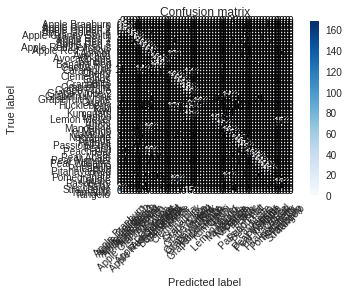

In [0]:
# plot_confusion_matrix(cm, labels)